# Sheet 2

In [1]:
import numpy as np
from matplotlib import pyplot as plt

## 1 Kernel Density Estimation
(a)

In [2]:
def biweight(x, mu, w):
    """biweight kernel at mean mu, with bandwidth w evaluated at x"""
    result = np.array(15 * (1 - ((x - mu) / w)**2)**2 / (16 * w)) # Implement the formula

    support_mask = np.abs(x - mu) > w # Find positions where the support is exeeded
    result[support_mask] = 0 # Enforce the support [-w,w]

    return result

Text(0, 0.5, '$k(x-mu, w)$')

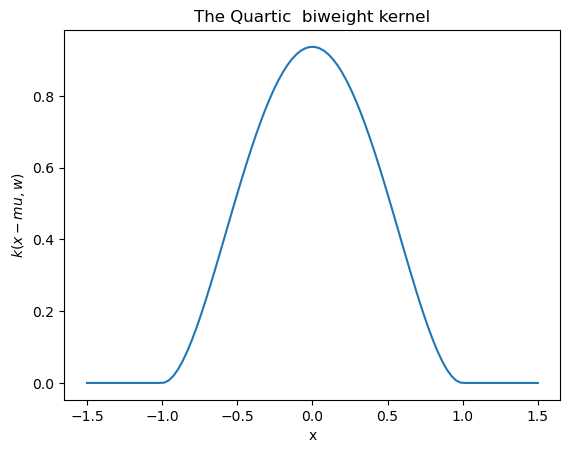

In [3]:
x, mu, w = np.linspace(-1.5, 1.5, 100), 0, 1

plt.title('The Quartic  biweight kernel')

plt.plot(x, biweight(x, mu, w))

plt.xlabel('x')
plt.ylabel('$k(x-mu, w)$')

(b)

In [4]:
# load the data
data = np.load("data/samples.npy")
data50 = data[:50]
print(f'{data.shape=}, {data50.shape=}')

data.shape=(10000,), data50.shape=(50,)


In [5]:
def kde(x, obs, w=1):
    result = np.vstack([biweight(x, mu, w) for mu in obs]) # This should be vectorizable...
    return result.mean(axis=0)

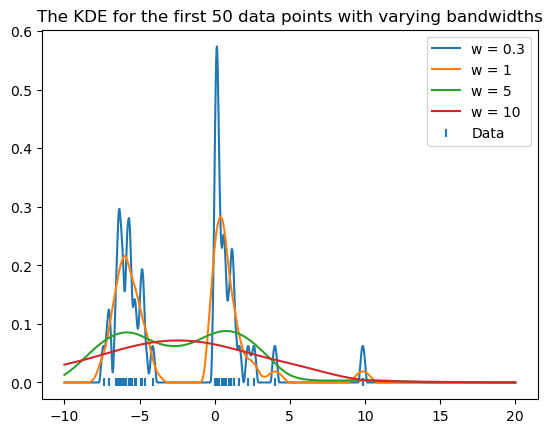

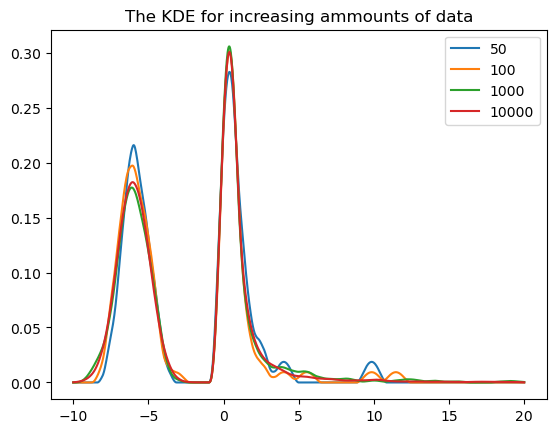

In [6]:
x = np.linspace(-10,20, 1000)

widths = [0.3, 1, 5, 10] 

plt.figure()
plt.title('The KDE for the first 50 data points with varying bandwidths')

for w in widths:
    plt.plot(x, kde(x, data50, w), label = f'w = {w}')

plt.scatter(data50, np.zeros(data50.shape), marker='|', label = 'Data')

plt.legend()



ammounts = [50, 100, 1000, 10000] 

plt.figure()
plt.title('The KDE for increasing ammounts of data')

for N in ammounts:
    dataN = data[:N]
    plt.plot(x, kde(x, dataN), label = N)

plt.legend()

We can see that the bandwidth has to be chosen well. If its too small the resulting density estimate is too jagged, when its too large distinct features of the true distribution blur together. <br>
The more data we include in our estimate the better it becomes because adverse effects of outliers are compensated.

## 3 Mean-Shift
(a) We want the formula for gradient ascent on the KDE with an Epanechnikov Kernel to be equal to the mean shift algorithm, thus:
$$x_j^{t+1} = x_j^t + a_j^t \frac{2}{n} \sum (x_i - x_j^t) = \frac{1}{n} \sum x_i$$
$$\implies 0 = x_j^t + a_j^t \frac{2}{n} \sum (x_i - x_j^t) - \frac{1}{n} \sum x_i$$
$$\implies 0 = x_j^t + 2 a_j^t \frac{1}{n} \sum x_i -  2 a_j^t \frac{1}{n} \sum x_j^t - \frac{1}{n} \sum x_i$$
$$\implies 0 = x_j^t (1 - 2 a_j^t) + a_j^t (\frac{1}{n} \sum x_i)$$
$$\implies a_j^t = - \frac{x_j^t}{x_j^t + \frac{1}{n} \sum x_i}$$
(b) Bonus

In [7]:
def mean_shift_step(x, xt, r=1):
    """
    A single step of mean shift, moving every point in xt to the local mean of points in x within a radious of r.
    
    Parameters
    ----------
    x : np.ndarray
        Array of points underlying the KDE, shape (d, N1)
    xt : np.ndarray
        Current state of the mean shift algorithm, shape (d, N2)
    n_components : int, optional
        Number of requested components. By default returns all components.
        
    Returns
    -------
    np.ndarray
        the points after the mean-shift step
    """

    if len(x.shape) == 1: x = x[None,:] # make sure one dimensional data is in the correct format
    if len(xt.shape) == 1: xt = xt[None,:]
    assert xt.shape[0] == x.shape[0], f'Shape mismatch: {x.shape[0]}!={xt.shape[0]}'
    
    dists = (x[:,:,None] - xt[:,None,:]) # calculate the difference x_i - xt_j
    dists = np.linalg.norm(dists, axis = 0) # calculate the distance |x_i - xt_j|, this is where we could apply different kernels

    mask = dists < r # threshold the distances
    
    local_means = np.zeros(xt.shape) # initialize the results array

    for j in range(xt.shape[1]):
        xtt_j = x[:,mask[:,j]] # isolate the neighboring x_i
        xtt_j = [0., 0.] if xtt_j.size == 0 else xtt_j.mean(axis = 1) # calculate the mean of the neighbours
        
        local_means[:,j] = xtt_j # save the result
    
    return local_means

Text(0.5, 0, 'time')

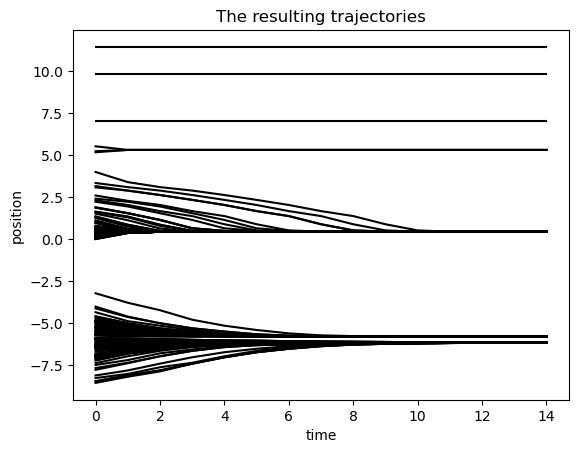

In [8]:
# load the data
data = np.load("data/samples.npy")
x = data[:200]
xt = x

trajectories = [xt[None,:]]
max_steps = 100

for step in range(max_steps):
    xt = mean_shift_step(x, xt)

    trajectories.append(xt)

    if np.allclose(trajectories[-1], trajectories[-2]):  # break in case of convergence
        break

trajectories = np.stack(trajectories)


# Plot the trajectories

plt.title('The resulting trajectories')

t = np.arange(0,trajectories.shape[0])
for i in range(trajectories.shape[2]):
    plt.plot(t, trajectories[:,0,i], color = 'black')

plt.ylabel('position')
plt.xlabel('time')

In [9]:
def mean_shift_step_blurring(xt, r=1):
    '''the mean shift step but with blurring'''
    if len(xt.shape) == 1: xt = xt[None,:] # make sure one dimensional data is in the correct format
    
    dists = (xt[:,:,None] - xt[:,None,:]) # calculate the difference x_i - xt_j
    dists = np.linalg.norm(dists, axis = 0) # calculate the distance |x_i - xt_j|, this is where we could apply different kernels

    mask = dists < r # threshold the distances
    
    local_means = np.zeros(xt.shape) # initialize the results array

    for j in range(xt.shape[1]):
        xtt_j = xt[:,mask[:,j]] # isolate the neighboring x_i
        xtt_j = [0., 0.] if xtt_j.size == 0 else xtt_j.mean(axis = 1) # calculate the mean of the neighbours
        
        local_means[:,j] = xtt_j # save the result
    
    return local_means

Text(0.5, 0, 'time')

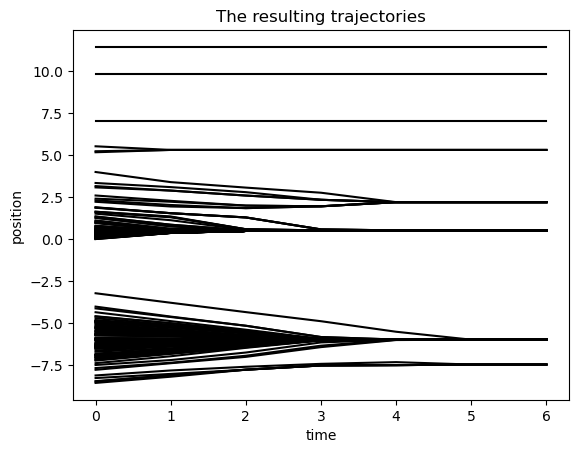

In [10]:
# load the data
data = np.load("data/samples.npy")
xt = data[:200]

trajectories = [xt[None,:]]
max_steps = 100

for step in range(max_steps):
    xt = mean_shift_step_blurring(xt)

    trajectories.append(xt)

    if np.allclose(trajectories[-1], trajectories[-2]):  # break in case of convergence
        break

trajectories = np.stack(trajectories)


# Plot the trajectories

plt.title('The resulting trajectories')

t = np.arange(0,trajectories.shape[0])
for i in range(trajectories.shape[2]):
    plt.plot(t, trajectories[:,0,i], color = 'black')

plt.ylabel('position')
plt.xlabel('time')

## 4 K-Means
Lets assume we have initialized the matrix $\bf{M}$ (for example by assigning a random class membership to each sample). Next we will update/initialize the matrix $\bf{C}$ as follows: <br>
Looking at the energy formula $E(\bf{C}, \bf{M}, K) = ||\bf{X} - \bf{M} \bf{C}||^2$ we see that the term $\bf{MC}$ is a mapping of clustercenters to the samples in X that are of that class. This means that $\bf{X} - \bf{MC}$ is just the difference between each sample and its clustercenter. <br>
If we restrict ourself to only change $\bf{C}$ then the optimal choice is to move it as close to each constituent as possible, while at the same time having a squared distance weighting, the result is to move each clustercenter to the mean position of its constituents. <br>
For the next step we restrict ourself to changing $\bf{M}$. In this case the optimal choice would be to ajust the class memberships such that $\bf{X} - \bf{MC}$ is as small as possible (in magnitude), ie: Assign each sample to the closest clustercenter.

(b)

In [11]:
from sklearn.cluster import KMeans

def kmeans_step(x, k, c=None, init='random'):
    """
    K-Means clustering on a p x N data matrix.
    
    Parameters
    ----------
    x : np.ndarray
        Data matrix of shape (p, N).
    k : int
        Number of cluster.
    c : np.ndarray, optional
        Current cluster centers. If None, the initialization as specified by 'init' will be used.
    init: str
        The initialization method to be used if c is None.
        
    Returns
    -------
    float, np.ndarray
        cost after the step, updated cluster centers
    """
    
    if c is not None:
        init = c
        assert c.shape[0] == k

        
    # Note: the documentation is your friend: 
    #       https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
    
    # TODO: set n_cluster, init, n_init and max_iter appropriately
    single_step_kmeans = KMeans(
        n_clusters = k, 
        init = init, 
        max_iter = 1,
        n_init = 1,
    )
    
    # TODO call the single_step_kmeans
    single_step_kmeans.fit(x)
    
    # TODO get the current energy (you don't have to compute it - it's stored in single_step_kmeans)
    E = single_step_kmeans.score(x)
    
    # TODO read out cluster centers 
    c = single_step_kmeans.cluster_centers_
    
    return E, c    

In [12]:
# load the data (you can try both with the full normalized feature and the 2d umap projection)

features = np.load('data/dijet_features_normalized.npy')  # full features
# features = np.load('data/dijet_features_umap.npy')      # umap projection

print(f'{features.shape=}')

features.shape=(116, 2233)


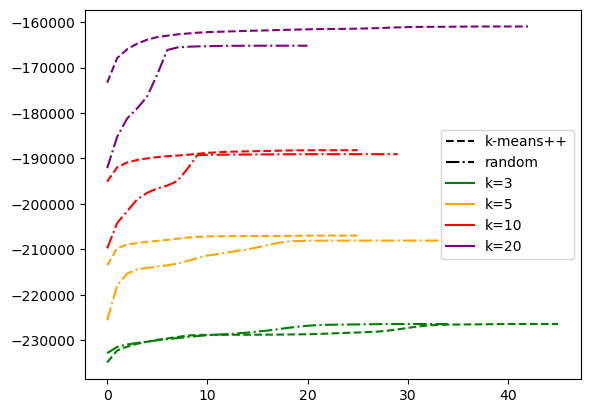

In [13]:
def kmeans(x, k, max_steps=100, init='random'):
    c = None
    energies = []  # list of energies over the iterations. 
    for i in range(max_steps):
        # Call the kmeans_step implemented above to get the energy and the next cluster centers
        E, c = kmeans_step(x, k=k, c=c, init=init)
        energies.append(E)
        
        # Stop the loop if there was no improvement
        if i>=2 and energies[-1] == energies[-2]:
            break
    energies = np.array(energies)
    return energies  # return array of energies

ks = [3, 5, 10, 20]
colors = dict(zip(ks, ['green', 'orange', 'red', 'purple']))
inits = ['k-means++', 'random']
formats = dict(zip(inits, ['--', '-.']))

for k in ks:
    for init in inits:
        # TODO: for the given k and init, run k-means 20 times or more (using the kmeans function above)
        #       and plot the resulting energy trajectores
        e = kmeans(features.T, k, init=init)
        plt.plot(e, color = colors[k], linestyle = formats[init])

plt.legend([plt.Line2D([0], [0], color = 'black', linestyle = '--'), 
            plt.Line2D([0], [0], color = 'black', linestyle = '-.'),
            plt.Line2D([0], [0], color = 'green', linestyle = '-'),
            plt.Line2D([0], [0], color = 'orange', linestyle = '-'),
            plt.Line2D([0], [0], color = 'red', linestyle = '-'),
            plt.Line2D([0], [0], color = 'purple', linestyle = '-')], 
            ['k-means++', 'random', 'k=3', 'k=5', 'k=10', 'k=20'])        

We can see that the a bigger cluster number results in a better overall score and faster convergence. <br>
This of course does not mean that a higher clusternumber is desirable! <br>
Another observation is, that the random initialization seems to converge faster for smaller clusternumbers and slower for bigger ones. I dont have an explanation for this.